# IMDB-CNN_LSTM-SIGMOD

아래의 결과를 실행하고 나타난 결과입니다.
[0.8828116548156738, 0.8505600001907349]

1. 실제 데이터에 대한 상세 기술 
 - IMDB(인터넷 영화 데이터베이스)의 데이터에서 제공한 데이터들 중 양극단(긍정적,부정적) 리뷰의 단어들의 데이터셋입니다.
 - 훈련 데이터로는 2만 5000개의 데이터와 같은 수의 테스트 데이터로 구성되어 있으며 훈련 데이터를 2만개와 검증 데이터 5천개로 나누어 진행할    것입니다.
 - 데이터의 내용은 빈도수가 가장 높은 5000개 단어들로 구성하였습니다.

In [10]:
#imdb에서 제공하는 데이터를 가져온는 과정
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Flatten, Dropout
from keras.layers import Conv1D, MaxPooling1D
from keras.utils.np_utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

max_features = 5000
text_max_words = 200

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=max_features)

In [11]:
#가져온 데이터의 갯수 파악
print("트레이닝 데이터 :", len(train_data))
print("테스트 데이터 :", len(test_data))

트레이닝 데이터 : 25000
테스트 데이터 : 25000


In [12]:
# 데이터 내용을 확인하기 위하여 index를 매핑시킬 수 있는 딕셔너리 생성
word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# 첫번째 데이터에 있는 문자 확인과 이 내용이 긍정적인지 부정적인지 같은 인덱스에 존재하는 레이블을 이용하여 확인
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[9]])

if train_labels[9] == 1 :
    print("긍정적인 내용")
else:
    print("부정적인 내용")
decoded_review

부정적인 내용


"? this movie has many problem associated with it that makes it come off like a low budget class project from someone in film school i have to give it credit on its ? though many times throughout the movie i found myself laughing ? it was so bad at times that it was comical which made it a fun watch br br if you're looking for a low grade slasher movie with a twist of psychological horror and a ? of campy ? then pop a ? of popcorn ? some friends over and have some fun br br i agree with other comments that the sound is very bad dialog is next to impossible to follow much of the time and the soundtrack is kind of just there"

2. 예측하고자 하는 방법/방향 기술 
 - 특정한 단어의 집합으로 이루어진 양극단 데이터를 학습시킨 모델에 데이터를 입력할 때에 그 데이터가 긍정인지 부정인지 예측하기위하여 진행    하였습니다.

In [13]:
#5. 생성된 모델의 model.summary() 출력
x_val = train_data[:20000]
partial_x_train = train_data[20000:]

y_val = train_labels[:20000]
partial_y_train = train_labels[20000:]

In [14]:
# 데이터를 벡터로 변환
x_val = sequence.pad_sequences(x_val, maxlen=text_max_words)
partial_x_train = sequence.pad_sequences(partial_x_train, maxlen=text_max_words)
x_test = sequence.pad_sequences(test_data, maxlen=text_max_words)

# 레이블의 자료형을 변경하여 불필요한 데이터 손실이 없게 변환
#y_train = np.asarray(y_val).astype('float32')
#partial_x_train = np.asarray(partial_y_train).astype('float32')
#y_test = np.asarray(test_labels).astype('float32')

3. 학습을 위해 데이터가 어떻게 가공/처리되었는지 기술 
 - 각 데이터마다 길이가 상이하므로 같은 길이로 맞추어 모델의 입력으로 사용하기 위해서 데이터 길이의 크기를 200으로 변경하였습니다.
   (모든 단어를 같은 길이로 맞춰주는 이유는 모델에서 데이터를 사용하기 위해서는 고정된 길이로 만들어줘야 하기 때문입니다.)
 - 레이블의 데이터는 스칼라 형식이므로 데이터 연산시 불필요한 데이터 손실이 없도록 정수형에서 실수형으로 변경하였습니다.

4. 사용된 모델의 특징에 대한 기술 
 - 이번 모델에서 사용한 레이어 중 중점인 레이어는 Conv1D, LSTM입니다.
 - 위의 레이어의 특징은 앞에서 설명하였으므로 생략하도록 하겠습니다.
 - 이 모델의 장점은 LSTM을 단독으로 사용해서 엄청나게 긴 데이터를 처리하기에 무리가 있으니 CNN을 LSTM 앞에다 두어서 필요성이 높은 노드를      선정하여 짧은 데이터로 변환을 시켜 좀 더 효율적인 학습을 시키기 위해서 사용합니다.

In [15]:
model = Sequential()
model.add(Embedding(max_features, 256, input_length=text_max_words))
model.add(Dropout(0.2))
model.add(Conv1D(256,
                 3,
                 padding='valid',
                 activation='relu',
                 strides=1))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [16]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [17]:
#각 층마다 사용되는 파라미터의 값과 구성이 어떻게 되었는지 간단하게 알 수 있음
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 256)          1280000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 200, 256)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 198, 256)          196864    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 49, 256)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 1,674,113
Trainable params: 1,674,113
Non-trainable params: 0
_________________________________________________________________


In [18]:
#epoch은 최소 25회 이상 진행 
hist = model.fit(x_val, y_val, epochs=25, batch_size=256, validation_data=(partial_x_train, partial_y_train))

Train on 20000 samples, validate on 5000 samples
Epoch 1/25
20000/20000 [==============================] - 662s 33ms/step - loss: 0.4863 - acc: 0.7384 - val_loss: 0.3276 - val_acc: 0.8688
Epoch 2/25
20000/20000 [==============================] - 657s 33ms/step - loss: 0.2563 - acc: 0.8977 - val_loss: 0.3254 - val_acc: 0.8706
Epoch 3/25
20000/20000 [==============================] - 656s 33ms/step - loss: 0.2038 - acc: 0.9216 - val_loss: 0.3151 - val_acc: 0.8740
Epoch 4/25
20000/20000 [==============================] - 631s 32ms/step - loss: 0.1704 - acc: 0.9365 - val_loss: 0.3545 - val_acc: 0.8612
Epoch 5/25
20000/20000 [==============================] - 633s 32ms/step - loss: 0.1193 - acc: 0.9601 - val_loss: 0.4239 - val_acc: 0.8620
Epoch 6/25
20000/20000 [==============================] - 632s 32ms/step - loss: 0.0812 - acc: 0.9748 - val_loss: 0.4830 - val_acc: 0.8598
Epoch 7/25
20000/20000 [==============================] - 635s 32ms/step - loss: 0.0689 - acc: 0.9773 - val_loss: 0.5

In [19]:
#그림으로 표현하기 위해서 history 데이터를 분리
history_dict = hist.history

acc = hist.history['acc']
val_acc = hist.history['val_acc']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(1, len(acc) + 1)

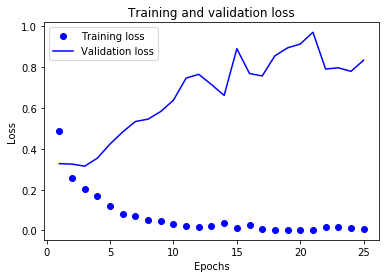

In [20]:
#손실을 그래프로 표시
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

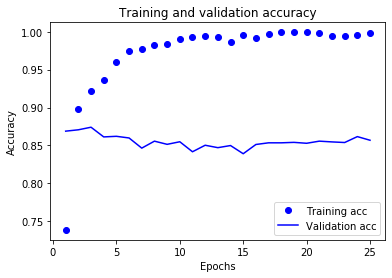

In [21]:
# 그래프를 초기화
plt.clf()  
#정확도를 그래프로 표시
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [23]:
# 6. 모델 평가하기
loss_and_metrics = model.evaluate(x_test, test_labels, batch_size=256)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

25000/25000 [==============================] - 31s 1ms/step
## evaluation loss and_metrics ##
[0.8828116548156738, 0.8505600001907349]


# CNN_LSTM 종료